# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from darwinian_shift import DarwinianShift, GlobalKmerSpectrum, TranscriptKmerSpectrum, EvenMutationalSpectrum
from darwinian_shift import CDFPermutationTest, ChiSquareTest, PermutationTest
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes

In [3]:
from darwinian_shift.additional_plotting_functions import plot_scatter_two_scores

In [4]:
from darwinian_shift.utils.sifts_functions import get_sifts_alignment
import os

# Setup

In [5]:
# Load data
data = pd.read_excel("aau3879_TableS2.xlsx", skiprows=17, sheet_name='Mutations_collapsed_by_distance')

In [6]:
# Define the region to test
section_definition_egf11_12 = {
    'transcript_id': 'ENST00000256646', 'pdb_id': '5mwb', 'pdb_chain': 'A', 
    'start': 415, 'end': 492 # Restrict to the residues in EGF11-12
}

In [7]:
# Define the mutational spectra
main_fig_spectrum=GlobalKmerSpectrum(
        k=3,  # Use a trinucleotide context,
        ignore_strand=False,  # Transcribed strand of the protein matters, so have 192 different mutation types
        deduplicate_spectrum=False,  # Do not remove duplicate mutations when calculating the spectrum
        name=''  # Use a blank name, so in the plots it will just say "Expected"
    )

In [8]:
# Define the statistical tests

cdf_perm = CDFPermutationTest(num_permutations=100000, testing_random_seed=0)  # Used to calculate p-values

chi_sq = ChiSquareTest(bins=[-0.1, 0.5, 1.1])  # Used to calculate counts for the discrete metrics

stats = [cdf_perm, chi_sq]

In [9]:
# Make a DarwinianShift object for the project. 
# This calculates the mutational spectrum, sets up the statistical tests to use, and filters the data. 
d = DarwinianShift(
    data=data, 
    source_genome='GRCh37',
    spectra=main_fig_spectrum,
    stats=[cdf_perm, chi_sq],
    
    # Just test with the missense mutations. Nonsense and synonymous mutations are still used to calculate the spectrum
    included_mutation_types='missense'
)

In [10]:
plot_directory="./NOTCH2_EGF11_12_figures/"
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)
    
sifts_directory="."
pdb_directory = "."

In [11]:
# Colours

unobserved_colour = '#BBBBBB'  
observed_colour = '#EE7733'

foldx_expected_colour = '#EE6677'
foldx_observed_colour = '#CC3311'

interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'

calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

# Defining all of the selected features

## FoldX

In [12]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="./FoldX_results/",
                      sifts_directory=sifts_directory,
                      foldx_file_name_start="PS_f*", download_sifts=True)

In [13]:
d_fold_all = d.change_lookup(fold)
s_fold_all = d_fold_all.run_section(section_definition_egf11_12, statistics=[cdf_perm])

In [14]:
s_fold_all.observed_mutations['ds_mut_id'].value_counts()  # No mutations recurring more than twice

120510091:T>C    2
120510178:C>T    2
120510721:C>T    2
120510184:C>T    2
120510217:C>T    1
120510098:A>T    1
120510720:T>A    1
120510149:C>T    1
120509103:C>A    1
120510131:A>G    1
120510059:G>C    1
120510715:C>A    1
120510083:C>T    1
120510082:C>A    1
120510235:T>C    1
120510233:G>T    1
120510091:T>A    1
120510211:C>A    1
120510134:C>T    1
120510071:A>T    1
120510230:A>G    1
120510711:T>G    1
120510161:C>T    1
120510151:C>G    1
120510169:C>T    1
120510151:C>T    1
120510166:T>C    1
120510056:C>T    1
120510185:A>G    1
120510225:C>A    1
120510196:C>A    1
120510148:T>G    1
120510115:C>T    1
120510229:C>A    1
Name: ds_mut_id, dtype: int64

## Interface

Use the interface residues defined in Suckling et al 2017

In [15]:
site1_residues = [470, 472, 473, 481]
site2_residues = [418, 421, 424, 425, 426, 428, 429, 439, 440, 452, 454, 456]
all_interface_residues = site1_residues + site2_residues

In [16]:
section_definition_egf11_12['interface_residues'] = all_interface_residues
section_definition_egf11_12['site1_residues'] = site1_residues
section_definition_egf11_12['site2_residues'] = site2_residues

In [17]:
# Define a lookup object which determines whether mutations are on the NOTCH1-ligand interface. 
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

## Calcium binding

Using the server MetalPDB https://academic.oup.com/nar/article/46/D1/D459/4564802  
http://metalweb.cerm.unifi.it

In [18]:
# Add the residues to the section definition dictionary.  
ca_binding_residues = [415, 416, 418, 435, 436, 439, 456, 457, 459, 473, 474]
section_definition_egf11_12['ca_binding_residues'] = ca_binding_residues

In [19]:
ca_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean binding/not binding. 
    target_key='ca_binding_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='Calcium binding'  # Label to appear on plot axes
)

# Testing selection

## FoldX

In [20]:
# First define a lookup that is 1 if the mutation is on the interface and or calcium binding
interface_or_ca_lookup = ORLookup(
    lookups=[interface_lookup, ca_lookup],  
    thresholds=[0.5, 0.5],  # Set thresholds at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for interface or calcium binding.
)


# Define the combined lookup.
excllook_foldx = MutationExclusionLookup(
    lookup=fold,   # Use the calcium binding lookup for the test
    exclusion_lookup=interface_or_ca_lookup,
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=fold.name
)

In [21]:
d_fold = d.change_lookup(excllook_foldx)

In [22]:
s_fold = d_fold.run_section(section_definition_egf11_12, statistics=[cdf_perm])

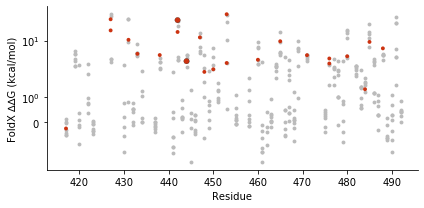

In [23]:
s_fold.plot_scatter(figsize=(6, 3), plot_scale='symlog', show_legend=False, 
                    unobserved_mutation_colour=unobserved_colour, 
                    missense_mutation_colour=foldx_observed_colour, 
                    unmutated_marker_size=15, base_marker_size=15,
                   )
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'scatter_foldx_efg11_12.pdf'), transparent=True)

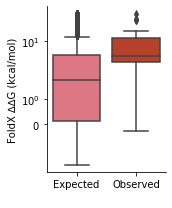

In [24]:
s_fold.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'boxplot_foldx_efg11_12.pdf'), transparent=True)

In [25]:
s_fold_results = s_fold.get_results_dictionary()

In [26]:
s_fold_results['num_mutations']

25

In [27]:
s_fold_results['CDF_perm__pvalue']  # P-value of the permutation test

1.999980000199998e-05

## Interface residues

In [28]:
# First define a lookup that is 1 if the mutation is destabilising or calcium binding
destabilising_or_ca_lookup = ORLookup(
    lookups=[fold, ca_lookup],  
    thresholds=[2, 0.5],  # Use 2kcal/mol as the ∆∆G threshold. Ca score is 0 or 1, so set threshold at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for calcium binding or > 2 for ∆G.
)


# Define the combined lookup.
excllook_interface = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=destabilising_or_ca_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=interface_lookup.name
)

In [29]:
d_interface1 = d.change_lookup(excllook_interface)

In [30]:
s_interface1 = d_interface1.run_section(section_definition_egf11_12)

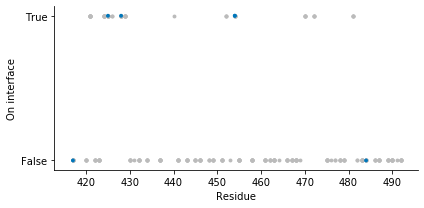

In [31]:
s_interface1.plot_scatter(figsize=(6, 3), show_legend=False, 
                          unobserved_mutation_colour=unobserved_colour, 
                          missense_mutation_colour=interface_observed_colour, 
                         base_marker_size=15, unmutated_marker_size=15)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'scatter_interface1_efg11_12.pdf'), transparent=True)

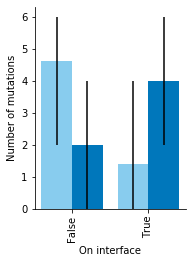

In [32]:
s_interface1.plot_binned_counts(figsize=(3, 4), show_legend=False,
                                     colours=[interface_observed_colour, interface_expected_colour])
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('On interface')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'bar_interface1_efg11_12.pdf'), transparent=True)

In [33]:
s_interface1_results = s_interface1.get_results_dictionary()

In [34]:
s_interface1_results['num_mutations']

6

In [35]:
s_interface1_results['CDF_perm__pvalue']  # P-value of the permutation test

0.05865941340586594

# Calcium binding residues

In [36]:
# First define a lookup that is 1 if the mutation is destabilising or on the interface and 0 otherwise.
destabilising_or_interface_lookup = ORLookup(
    lookups=[fold, interface_lookup],  # Use the FoldX and the interface lookups.  
    thresholds=[2, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are both 1.
)


# Define the combined lookup.
excllook_ca = MutationExclusionLookup(
    lookup=ca_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=destabilising_or_interface_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=ca_lookup.name
)

In [37]:
d_ca2 = d.change_lookup(excllook_ca)

In [38]:
s_ca2 = d_ca2.run_section(section_definition_egf11_12)

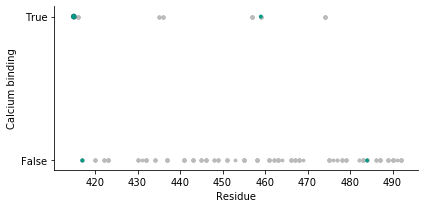

In [39]:
s_ca2.plot_scatter(figsize=(6, 3), show_legend=False, 
                  unobserved_mutation_colour=unobserved_colour, 
                   missense_mutation_colour=calcium_observed_colour,
                  base_marker_size=15, unmutated_marker_size=15)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'scatter_ca2_efg11_12.pdf'), transparent=True)

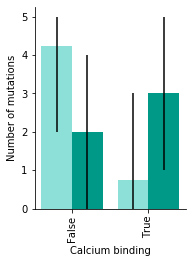

In [40]:
s_ca2.plot_binned_counts(figsize=(3, 4), show_legend=False, spectra=main_fig_spectrum,
                              colours=[calcium_observed_colour, calcium_expected_colour])
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('Calcium binding')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'bar_ca2_efg11_12.pdf'), transparent=True)

In [41]:
s_ca2_results = s_ca2.get_results_dictionary()

In [42]:
s_ca2_results['num_mutations']

5

In [43]:
s_ca2_results['CDF_perm__pvalue']  # P-value of permutation test

0.05307946920530795

# Testing for interface or calcium binding

The numbers are very low for mutations that are exclusively in one of these two categories.    
We can increase the power by including both categories together.  
This will increase the sample size to more than just the sum of the two cases, since we can now include mutations that both calcium binding and on the ligand interface.  
The downside is that we cannot distinguish which feature is selected for, but the individual results show that there is a trend of selection in both cases, even if not significant.  

In [44]:
# Define the combined lookup.
excllook_interface_or_ca = MutationExclusionLookup(
    lookup=interface_or_ca_lookup,   # True if either on the interface or calcium binding
    exclusion_lookup=fold,   # Use the foldX lookup to exlcude mutations that have large ∆∆G values 
    exclusion_threshold=2,  #  Exclude destabilising mutations with ∆∆G > 2kcal/mol
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threshold from the exclusion_lookup.
    name="On interface or calcium binding"
)

In [45]:
d_int_or_ca = d.change_lookup(excllook_interface_or_ca)

In [46]:
s_int_or_ca = d_int_or_ca.run_section(section_definition_egf11_12)

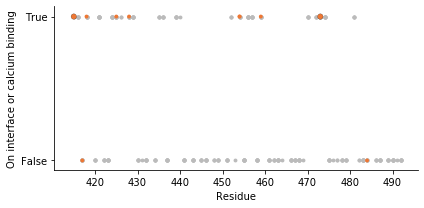

In [47]:
s_int_or_ca.plot_scatter(figsize=(6, 3), show_legend=False, 
                  unobserved_mutation_colour=unobserved_colour, 
                   missense_mutation_colour=observed_colour,
                  base_marker_size=15, unmutated_marker_size=15)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'scatter_int_or_ca_efg11_12.pdf'), transparent=True)

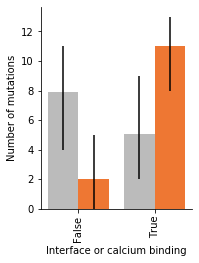

In [48]:
s_int_or_ca.plot_binned_counts(figsize=(3, 4), show_legend=False, spectra=main_fig_spectrum,
                              colours=[observed_colour, unobserved_colour])
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('Interface or calcium binding')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'bar_int_or_ca_efg11_12.pdf'), transparent=True)

In [49]:
s_int_or_ca_results = s_int_or_ca.get_results_dictionary()

In [50]:
s_int_or_ca_results['num_mutations']

13

In [51]:
s_int_or_ca_results['CDF_perm__pvalue']  # P-value of permutation test

0.001979980200197998

# Mutation categories

In [52]:
target_selection_string = 'protein and segid A and resid {} and name CA'.format(
    " ".join([str(int(p)) for p in section_definition_egf11_12['interface_residues']]))
section_definition_egf11_12['interface_residues_3D'] = target_selection_string


# Define the lookup that measure the distance in the structure from these selected residues
interface_lookup3D = StructureDistanceLookup(
    boolean=False,  # This time we use the distance
    target_key='interface_residues_3D', 
    name='Distance from interface residues (A)',
    
    # Uses the pdb file and SIFTS. Provide paths to directories including those files.
    pdb_directory=pdb_directory,
    sifts_directory=sifts_directory, 
    download_sifts=True   # Download the SIFTS file if not already in the directory

)

In [53]:
d_interface3D = d.change_lookup(interface_lookup3D)
s_interface3D = d_interface3D.run_section(section_definition_egf11_12)

/Users/mh28/miniconda3/envs/ds/lib/python3.7/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


In [54]:
d_ca_all = d.change_lookup(ca_lookup)
s_ca_all = d_ca_all.run_section(section_definition_egf11_12, statistics=[cdf_perm])

In [55]:
d_interface_all = d.change_lookup(interface_lookup)
s_interface_all = d_interface_all.run_section(section_definition_egf11_12, statistics=[cdf_perm])

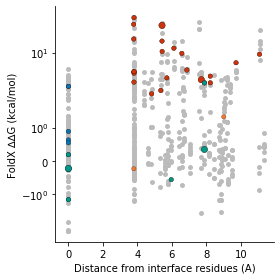

In [56]:
plot_scatter_two_scores(s_interface3D, s_fold_all, 
                        sections_for_colours=[s_fold_all, s_interface3D, s_ca_all], 
                        score_regions_for_colours=[[2, 100], [-1, 0.1], [0.9,1.1]],
                        score_region_colours=[foldx_observed_colour, interface_observed_colour, calcium_observed_colour],
                        unobserved_mutation_colour=unobserved_colour, 
                        missense_mutation_colour=observed_colour,
                        plot_yscale='symlog', show_legend=False, figsize=(4, 4), unmutated_marker_size=15,
                        base_marker_size=20, annotate_mutations=False, annotate_xregion=[2, 10],
                            annotate_yregion=[-10000, 1.5], annotate_min_count=3, annotate_column='aachange',
                            annotation_offset=(-1.6, 0))
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'foldX_vs_interface_distance_notch2.pdf'), transparent=True)